<a href="https://colab.research.google.com/github/Aischy/MPA-MLF/blob/main/Ex_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPA-MLF, Lab 6 - Feedforward Neural Networks with regularization techniques and hyperparameter tunning

## Exercise 1 - Classification of an images

The goal of this task will be to create Multi-layer perceptron model, that is able to recognize the  CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR10 dataset consist of 60000 images with resolution of 32x32 pixels. There are 10 classes in total - *airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*

These is an example of the dataset:

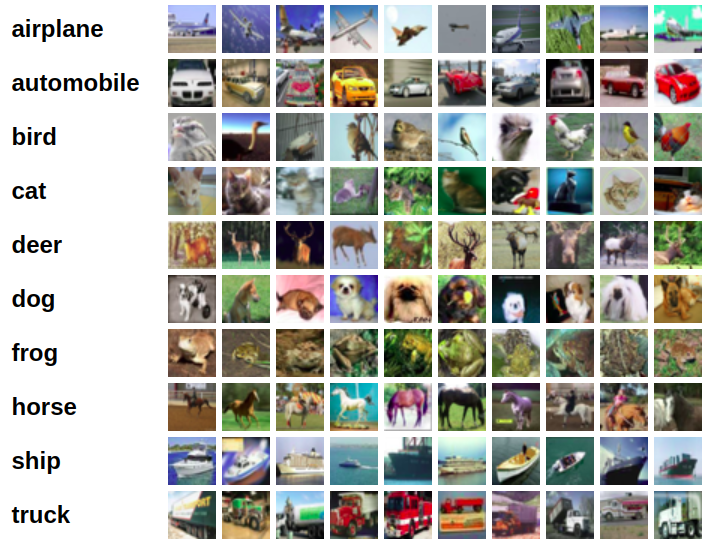

### 0. Import libraries

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

### 1. Load the Dataset
The dataset is already a part of the Keras library, so we can quickly load it using the following command

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

The following numbered labels represent the labels in the dataset:

In [ ]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

### 2. Data Examination

Fistly, lets have a look and the couple of images we have,

In [ ]:
def display_random_images(x_data: np.array, y_data: np.array, count: int = 10) -> None:
  index = np.array(len(x_data))
  selected_ind = np.random.choice(index, count)

  selected_img = x_data[selected_ind]
  selected_labels_encoded = y_data[selected_ind]
  selected_labels = [labels[x[0]] for x in selected_labels_encoded]

  concat_img = np.concatenate(selected_img, axis=1)

  plt.figure(figsize=(20,10))
  plt.imshow(concat_img)

  for id_label, label in enumerate(selected_labels):
    plt.text((32/2) + 32*id_label - len(label), 32*(5/4), label)
  plt.axis('off')
  plt.show()



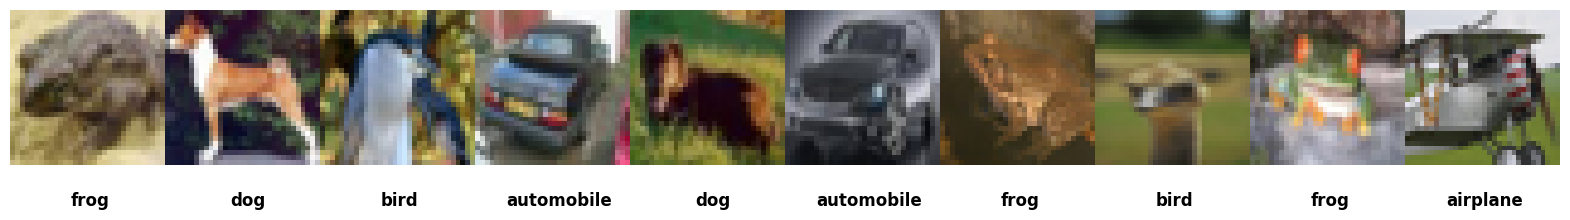

In [ ]:
display_random_images(X_train, y_train)

In [ ]:
#check the shape of image dataset

X_train.shape

(50000, 32, 32, 3)

In our dataset, we have 60000 images with 32x32 resolution. Each image has three channels (R, G, B). We have 50000 images for training and 10000 images for testing. Each channel for each image has values from 0 - 255, where each number represents the pixel intensity.
With the combination of intensities of R, G and B, you can display up to 16,777,216 different colours (256^3)

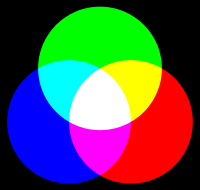

Here you can display each channel separately:

In [ ]:
def display_channels_separately(image: np.array) -> None:

  plt.figure()
  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))


  axs[0].imshow(image[:,:,0],cmap='Reds')
  axs[1].imshow(image[:,:,1],cmap='Blues')
  axs[2].imshow(image[:,:,2],cmap='Greens')

  axs[3].imshow(image)

  plt.show()

<Figure size 640x480 with 0 Axes>

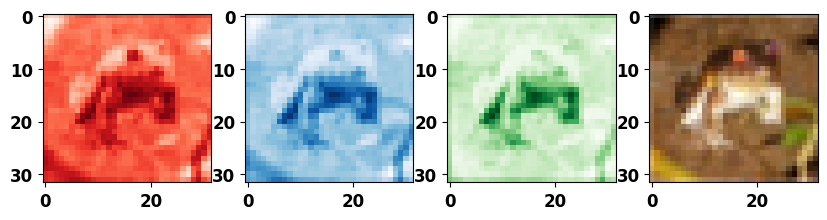

In [ ]:
display_channels_separately(X_train[0])

### 3. Preprocessing of the images

For machine learning purposes, we have to preprocess our images. Firstly we need to scale our images, to scale intensity values from 0-1 (min-max scaling)

In [ ]:
X_train_scaled = X_train.astype('float32') / 255.0

We need to one-hot-encode the labels in our ground truth variable as our second preprocessing.

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=10)

### 4. Define the model architecture

In [ ]:
model = Sequential([

    # CNN : Convolution and pooling layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),

    # Dense layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

We will define *the Sequential* model as in our last exercise. This time we will use a different approach to determine the input layers. Instead of specifying the *input_dim* parameter in our first hidden layer, we will create a **Flatten** layer that takes our 32x32x3 image and reshapes it into 1x3072.

We will specify ten neurons in our output layer because we have 10 possible outputs and a **softmax** activation function that returns us a probability distribution over the classes. The class with the highest probability is typically chosen as the predicted class for a given input.

Check the description of our model:

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_10 (Flatten)        (None, 1024)            

The next step is to compile our model, we will use *categorical_crossentropy* as a loss function, *stochastic gradient descend* as an optimisation and we will be checking *the accuracy* metric.

In [ ]:
optimizer = Adam(learning_rate = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### 5. Train the model

Our model will be trained in the same way as in our last pc_labs,

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4) # Define callback for early stop

history = model.fit(X_train_scaled, y_train_encoded, epochs=150, batch_size=512, validation_split = 0.2)

Epoch 1/150
79/79 [==============================] - 4s 25ms/step - loss: 4.3497 - accuracy: 0.1349 - val_loss: 3.9277 - val_accuracy: 0.1941
Epoch 2/150
79/79 [==============================] - 2s 20ms/step - loss: 3.6821 - accuracy: 0.2007 - val_loss: 3.3949 - val_accuracy: 0.2722
Epoch 3/150
79/79 [==============================] - 2s 21ms/step - loss: 3.2309 - accuracy: 0.2524 - val_loss: 2.9824 - val_accuracy: 0.3295
Epoch 4/150
79/79 [==============================] - 2s 22ms/step - loss: 2.9044 - accuracy: 0.3059 - val_loss: 2.7050 - val_accuracy: 0.3696
Epoch 5/150
79/79 [==============================] - 2s 25ms/step - loss: 2.6707 - accuracy: 0.3473 - val_loss: 2.5074 - val_accuracy: 0.3937
Epoch 6/150
79/79 [==============================] - 2s 20ms/step - loss: 2.4919 - accuracy: 0.3806 - val_loss: 2.3528 - val_accuracy: 0.4127
Epoch 7/150
79/79 [==============================] - 2s 20ms/step - loss: 2.3596 - accuracy: 0.4014 - val_loss: 2.2384 - val_accuracy: 0.4347
Epoch 

### 6. Model evaluation

In [ ]:
X_test_scaled = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [ ]:
score = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 1.0239871740341187
Test accuracy: 70.60999870300293 %


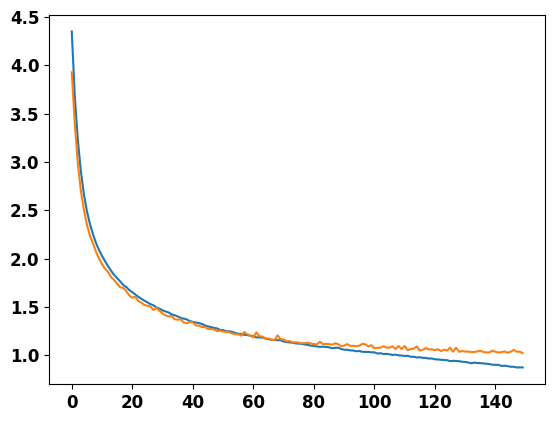

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

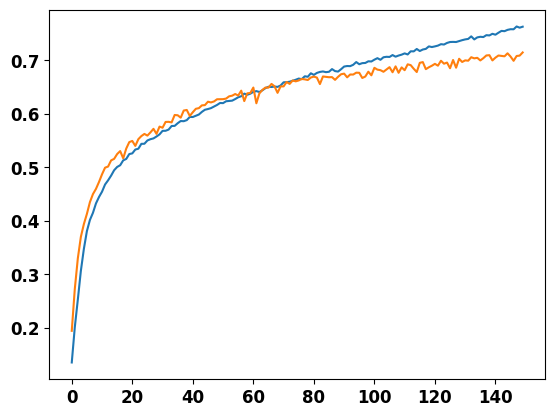

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

As you can see from the evaluation above, we was able to achive approx. 30% of an accuracy. In other word approx. 70% of an images we classified wrongly. That is really bad!

Lets check the best predictions from our model:

In [ ]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
  mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

  predictions = model.predict(x_test)
  y_test = y_test.reshape(1,-1)
  predictions_ind = np.argmax(predictions, axis=1)
  predictions_ind = predictions_ind.reshape(1, -1)

  corect_predictions = np.where(predictions_ind == y_test)

  rows_correct = corect_predictions[1]
  predictedtions_correct = predictions[rows_correct]
  target_correct = y_test[0][rows_correct]

  max_samples = predictions[rows_correct, target_correct]
  selected_images = x_test[rows_correct]
  sorted_ind = np.argsort(max_samples)[::-1]


  images = []
  prob = []
  labels = []


  for ind in range(n_of_pred):

    index = sorted_ind[ind]

    labels.append(target_correct[index])
    prob.append(max_samples[index])
    images.append(selected_images[index])

  plt.figure(figsize=(20,10))

  images = np.concatenate(np.asarray(images),axis=1)
  plt.imshow(images)
  for ins in range(n_of_pred):
    texts = '{}: \n{:.3f} %'.format(mapping[labels[ins]], prob[ins]*100)
    plt.text((32/2) + 32*ins - len(mapping[labels[ins]]), 32*(5/4), texts)

  plt.axis('off')
  plt.show()


313/313 [==============================] - 5s 17ms/step


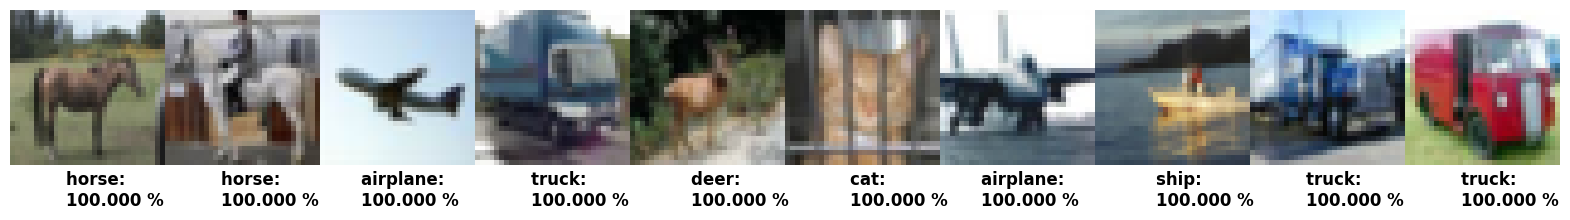

In [ ]:
show_the_best_predictions(model, X_test, y_test)

### Task Description:

You task of this exercise would be to improve the model's performance to achieve better results in image classification task. There is no need to change the preprocessing of the dataset. There are possible way how to improve the models performance:

1. Hyperparameter tunning - change the hyperparameters so that the model will perform better. You can experiment with the following:
 - *changing the number of neurons in the hidden layer*
 - *changing the number of hidden layers*
 - *changing the activation functions*
 - *changing the learning rate*
 - *changing the optimizer* - So far, we have used only Gradient descend as our optimizer, but Keras offers other algorithms that can perform better - check the documentation!
 - *changing the number of learning epochs*\
 - *changing the batch size*

2. Regularization techniques - There are several regularization techniques that can improve the model's performance:
 - *Dropout* -  In the Keras lib. you can add *dropout layer* into your Sequential model using the following command  *model.add(Dropout(p))* where *p* is an hyperparameter that controls dropout probabily, typical values are 0.1 - 0.5.
 - *L1, L2 regularization* - In keras the regularization is applied for selected layers, there is an example how to add l2 regularization to an layer (for more details check the documnetation):  *model.add(Dense(64, activation='relu', input_dim=100, kernel_regularizer=l2(0.01)))*
 - *Early stopping* -  In Keras, you can use the EarlyStopping callback to implement early stopping in your model. *early_stopping = EarlyStopping(monitor='val_loss', patience=3)*,  *model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])*


Try to make the highest testing accuracy possible. You can directly edit the code that is presented above, or you can copy everything into new cells. Please submit only the code with the best performance and briefly describe what approaches you have tried and what were the results

### WRITE YOUR DESCRIPTION IN THIS CELL ###

I first attempted to optimize the hyperparameters using the code below. I tried the most probable hyperparameter values and checked each time whether it increased the accuracy or not. This led to an improvement from 21.96% to 48.76%.

Here are the results obtained:

* Number of neurons in the hidden layer: 128
* Number of hidden layers: 3
* Activation functions: relu
* Learning rate: 0.001
* Optimizer: adam
* Number of learning epochs: 10
* Batch size: 128

Next, I experimented with regularization techniques. Dropout and L1-L2 regularization yielded similar results, increasing the accuracy by 1 to 2%. However, I opted for early stopping, which significantly boosted the accuracy compared to the other methods (~51-52%) at that moment.

Finally, after researching online, I discovered that a CNN model would likely yield better results in a scenario like this. Therefore, I attempted to implement convolutional layers. By adjusting the learning rate to 0.0001 and increasing the number of epochs to 100, I achieved an accuracy of 66.87%.

Below are the accuracy result curves obtained:

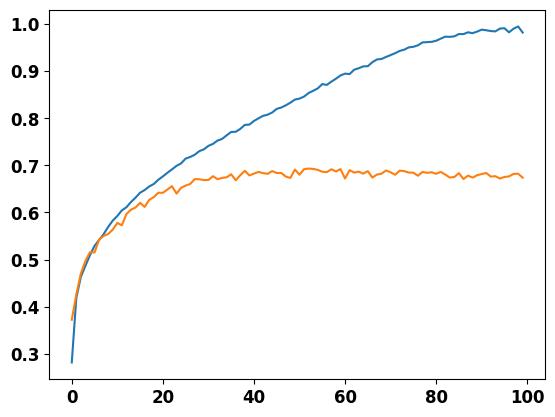

From around epoch 40, we can observe a widening gap between the training data accuracy and the validation data accuracy. This indicates that the model is beginning to overfit the training data, resulting in poorer performance on the validation data.

Therefore, I decided to incorporate the Dropout and L2 regularization functions, which become significantly important starting from epoch 40 to mitigate overfitting. After trying various combinations, I settled on a Dropout value of 0.2 and an L2 value of 0.002. Additionally, I increased the batch_size to 512 and the number of epochs to 150. This resulted in an accuracy of 70.61%.

Below are the corresponding curves, demonstrating a fairly stable model:

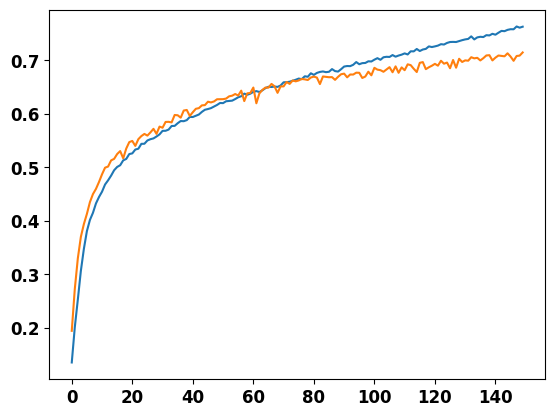

### Voluntary task:
Implement one of the hyperparameter tunning algorithms discussed in the lecture, such as *Grid Search*, *Random Search* or more sophisticated ones. Some of these algorithms are already included in the Keras. Check the documentation

# My tests

## Search of optimized hyperparameters

In [ ]:
# Function to run all the steps in function of hyperparameters
def train_and_evaluate_model(num_neurons: int, num_hidden_layers: int, activation_function: str, learning_rate: float, optimizer_name: str, epochs: int, batch_size: int) -> float:

    # Load the dataset
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    labels = {0: 'avion', 1: 'automobile', 2: 'oiseau', 3: 'chat', 4: 'cerf', 5: 'chien', 6: 'grenouille', 7: 'cheval', 8: 'navire', 9: 'camion'}

    # Preprocessing
    X_train_scaled = X_train.astype('float32') / 255.0
    y_train_encoded = to_categorical(y_train, num_classes=10)

    # Model architecture
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    for _ in range(num_hidden_layers):
        model.add(Dense(num_neurons, activation=activation_function))
    model.add(Dense(10, activation='softmax'))

    # Choice of optimizer
    if optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not supported")

    # Model compilation
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Model training
    history = model.fit(X_train_scaled, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Model evaluation
    X_test_scaled = X_test.astype('float32') / 255.0
    y_test_encoded = to_categorical(y_test, num_classes=10)

    score = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
    accuracy = score[1]*100

    # Show the best predictions
    show_the_best_predictions(model, X_test, y_test)

    # Return of % of succeed
    return accuracy


313/313 [==============================] - 1s 2ms/step


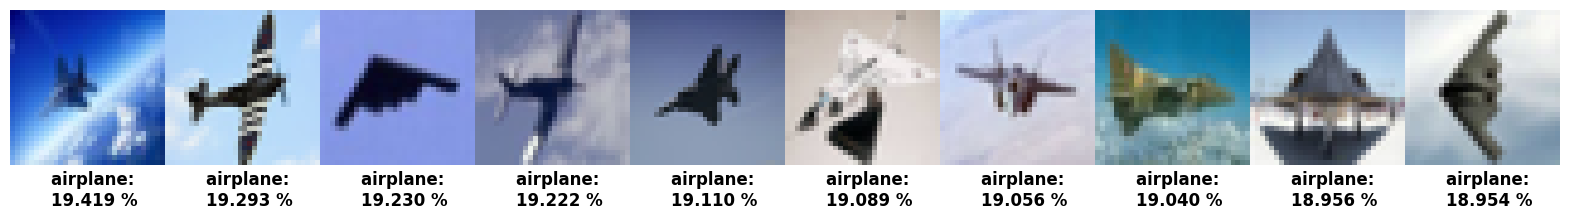

Accuracy of test model : 23.51%


In [ ]:
# Test of the function with the same hyperparameters as before
accuracy = train_and_evaluate_model(num_neurons=128, num_hidden_layers=2, activation_function='sigmoid', learning_rate=0.001, optimizer_name='sgd', epochs=20, batch_size=128)
print(f"Accuracy of test model : {accuracy:.2f}%")

313/313 [==============================] - 1s 2ms/step


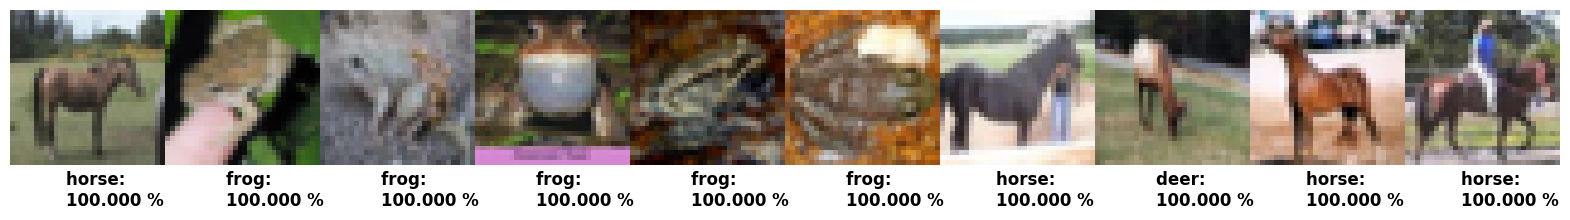

Best accuracy :  25.009998679161072
313/313 [==============================] - 1s 2ms/step


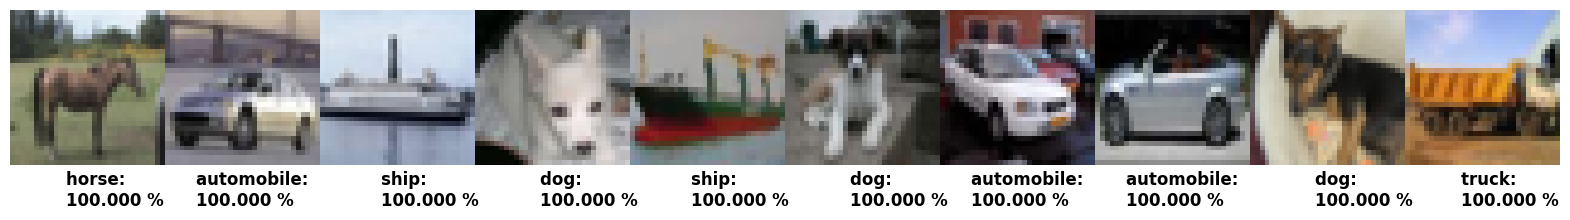

313/313 [==============================] - 1s 3ms/step


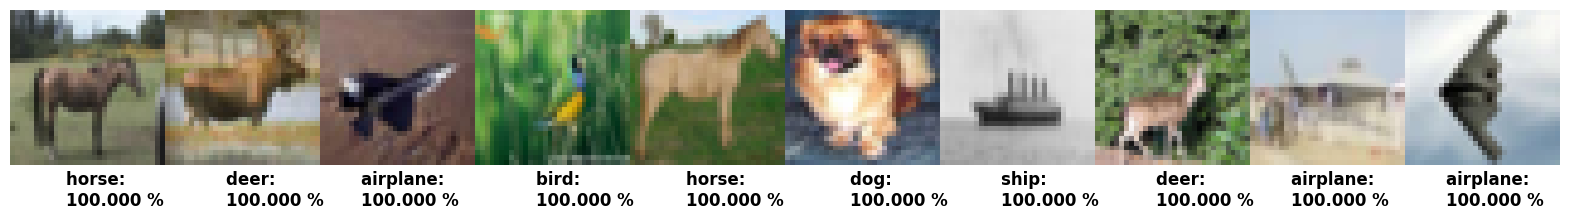

best_num_neur :  128
Best accuracy :  44.65000033378601
313/313 [==============================] - 1s 3ms/step


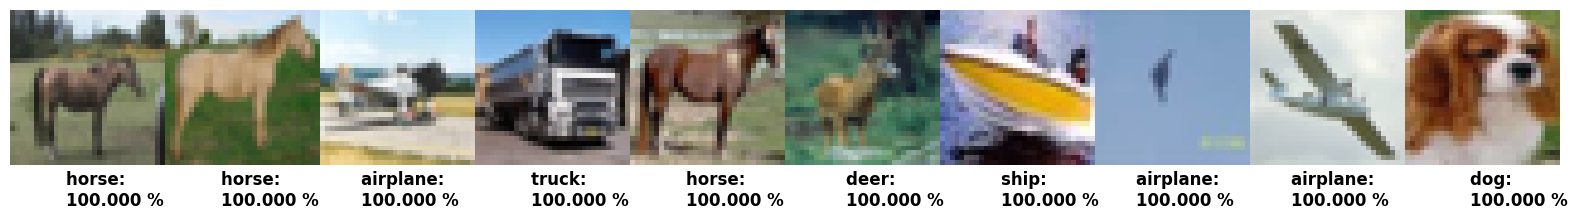

313/313 [==============================] - 1s 2ms/step


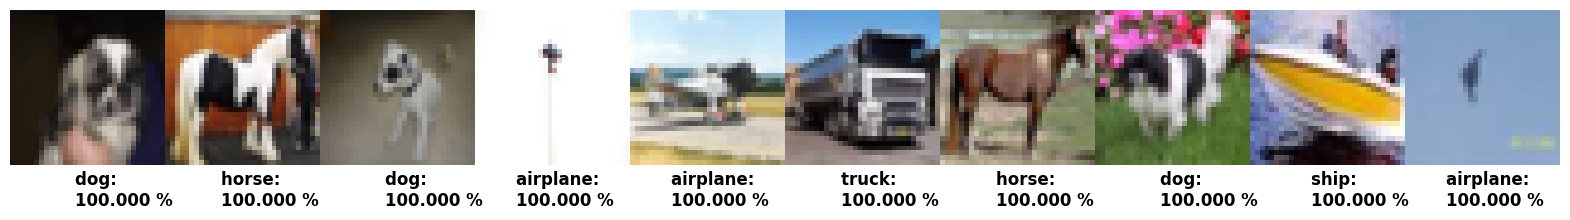

best_num_hidden_layers :  3
Best accuracy :  47.9200005531311
313/313 [==============================] - 1s 3ms/step


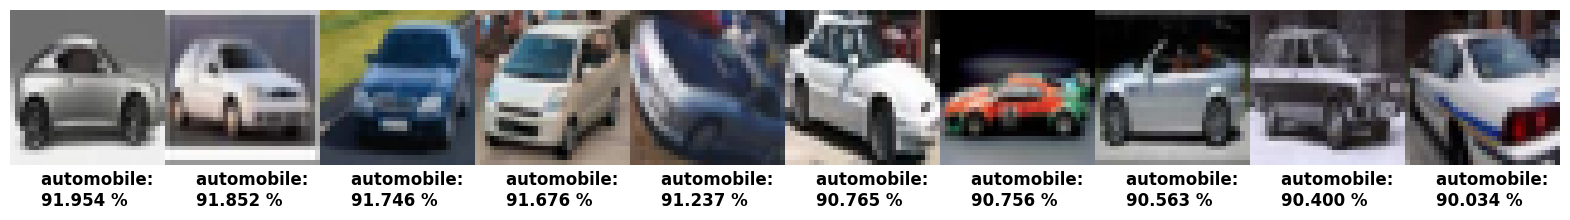

313/313 [==============================] - 1s 3ms/step


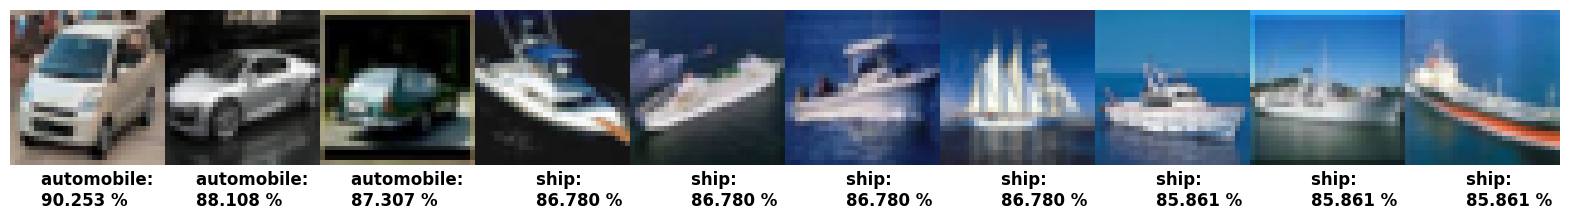

best_act_func :  relu
Best accuracy :  47.9200005531311
313/313 [==============================] - 1s 2ms/step


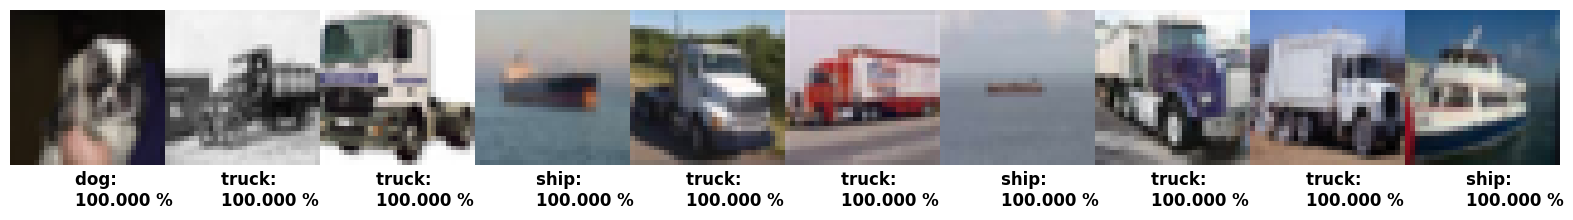

313/313 [==============================] - 1s 2ms/step


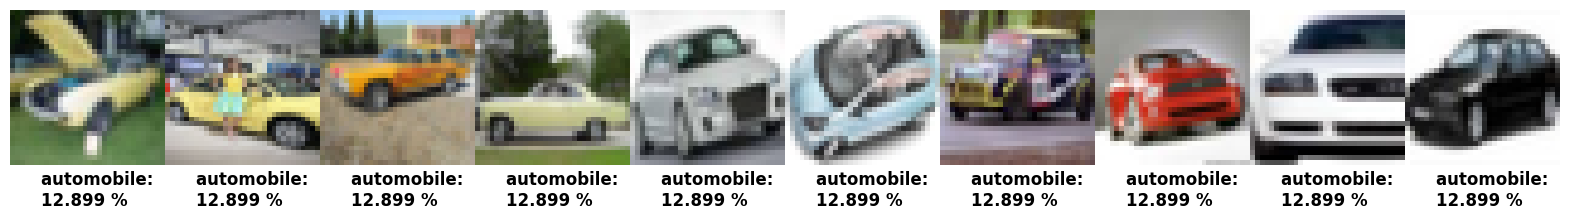

best_learning_rate :  0.001
Best accuracy :  47.9200005531311
313/313 [==============================] - 1s 3ms/step


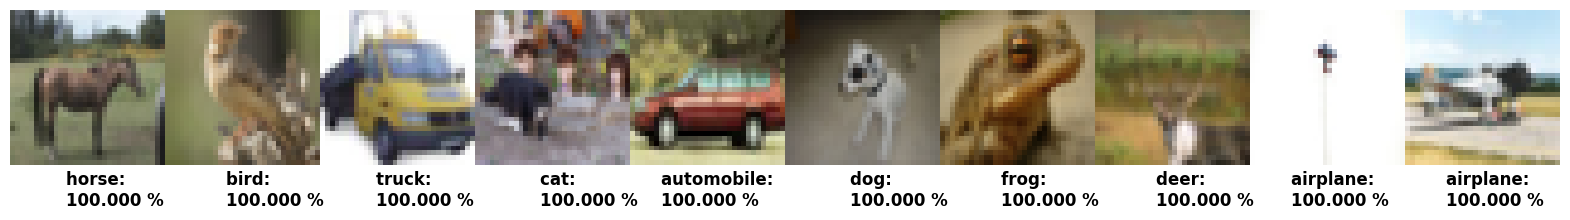

313/313 [==============================] - 1s 2ms/step


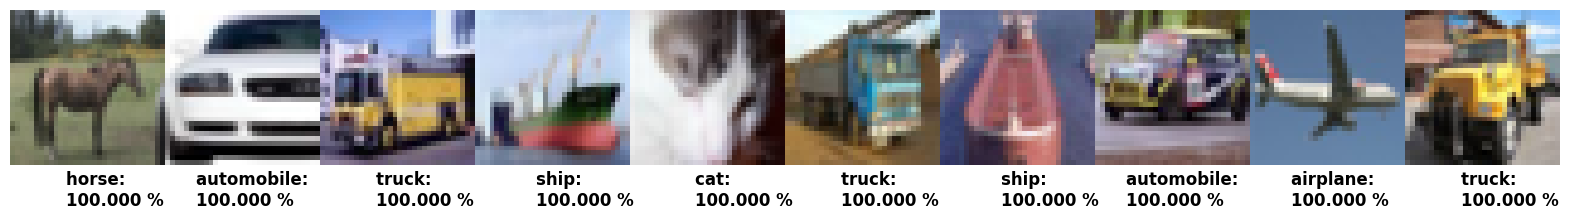

best_optimizer :  adam
Best accuracy :  47.9200005531311
313/313 [==============================] - 1s 3ms/step


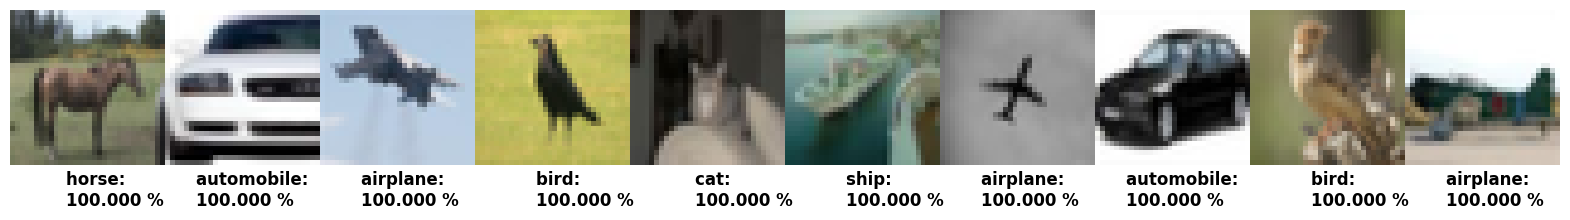

313/313 [==============================] - 1s 3ms/step


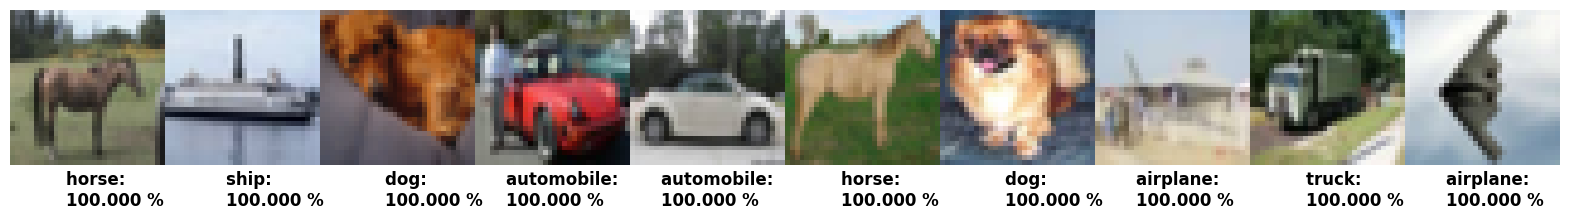

best_epochs :  10
Best accuracy :  47.9200005531311
313/313 [==============================] - 1s 2ms/step


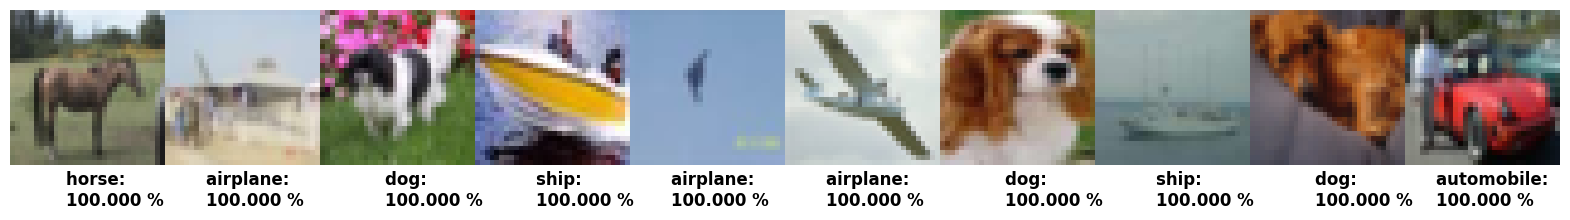

313/313 [==============================] - 1s 3ms/step


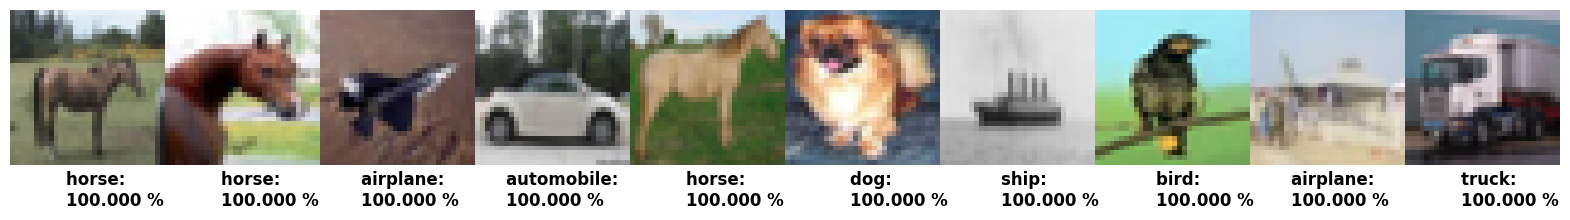

best_batch_size :  128
Best accuracy :  48.980000615119934
Best accuracy :  48.980000615119934


In [ ]:

# Lists of the most probables hyperparameters
num_neurons_list = [64,128,256]
num_hidden_layers_list = [1,2,3]
act_func_list = ['relu','sigmoid','tanh']
learning_rate_list = [0.001,0.01,0.1]
optimizers_list = ['adam','sgd','rmsprop']
epochs_list = [10,20,30]
batch_size_list = [32,64,128]

# Initialisation
best_num_neur = num_neurons_list[0]
best_num_hidden_layers = num_hidden_layers_list[0]
best_act_func= act_func_list[0]
best_learning_rate = learning_rate_list[0]
best_optimizer = optimizers_list[0]
best_epochs = epochs_list[0]
best_batch_size = batch_size_list[0]

best_accuracy = train_and_evaluate_model(best_num_neur, best_num_hidden_layers, best_act_func, best_learning_rate, best_optimizer, best_epochs, best_batch_size)
print("Best accuracy : ", best_accuracy)

# Find better hyperparameters in each list
for num_neur in num_neurons_list[1:] :
  accuracy = train_and_evaluate_model(num_neur, best_num_hidden_layers, best_act_func, best_learning_rate, best_optimizer, best_epochs, best_batch_size)
  if accuracy > best_accuracy:
    best_num_neur = num_neur
    best_accuracy = accuracy
print("best_num_neur : ", best_num_neur)
print("Best accuracy : ", best_accuracy)

for num_hidden_layers in num_hidden_layers_list[1:] :
  accuracy = train_and_evaluate_model(best_num_neur, num_hidden_layers, best_act_func, best_learning_rate, best_optimizer, best_epochs, best_batch_size)
  if accuracy > best_accuracy:
    best_num_hidden_layers = num_hidden_layers
    best_accuracy = accuracy
print("best_num_hidden_layers : ", best_num_hidden_layers)
print("Best accuracy : ", best_accuracy)

for act_func in act_func_list[1:] :
    accuracy = train_and_evaluate_model(best_num_neur, best_num_hidden_layers, act_func, best_learning_rate, best_optimizer, best_epochs, best_batch_size)
    if accuracy > best_accuracy:
        best_act_func = act_func
        best_accuracy = accuracy
print("best_act_func : ", best_act_func)
print("Best accuracy : ", best_accuracy)

for learning_rate in learning_rate_list[1:] :
    accuracy = train_and_evaluate_model(best_num_neur, best_num_hidden_layers, best_act_func, learning_rate, best_optimizer, best_epochs, best_batch_size)
    if accuracy > best_accuracy:
        best_learning_rate = learning_rate
        best_accuracy = accuracy
print("best_learning_rate : ", best_learning_rate)
print("Best accuracy : ", best_accuracy)

for optimizer in optimizers_list[1:] :
    accuracy = train_and_evaluate_model(best_num_neur, best_num_hidden_layers, best_act_func, best_learning_rate, optimizer, best_epochs, best_batch_size)
    if accuracy > best_accuracy:
        best_optimizer = optimizer
        best_accuracy = accuracy
print("best_optimizer : ", best_optimizer)
print("Best accuracy : ", best_accuracy)

for epochs in epochs_list[1:] :
    accuracy = train_and_evaluate_model(best_num_neur, best_num_hidden_layers, best_act_func, best_learning_rate, best_optimizer, epochs, best_batch_size)
    if accuracy > best_accuracy:
        best_epochs = epochs
        best_accuracy = accuracy
print("best_epochs : ", best_epochs)
print("Best accuracy : ", best_accuracy)

for batch_size in batch_size_list[1:] :
    accuracy = train_and_evaluate_model(best_num_neur, best_num_hidden_layers, best_act_func, best_learning_rate, best_optimizer, best_epochs, batch_size)
    if accuracy > best_accuracy:
        best_batch_size = batch_size
        best_accuracy = accuracy
print("best_batch_size : ", best_batch_size)
print("Best accuracy : ", best_accuracy)



### Final :
print("Best accuracy : ", best_accuracy)




Results :
* Number of neurons in the hidden layer : 128
* Number of hidden layers : 3
* Activation functions : relu
* Learning rate : 0.001
* Optimizer : adam
* Number of learning epochs : 10
* Batch size : 128

Accuracy with this hyperparameters : 48.98 %

313/313 [==============================] - 1s 2ms/step


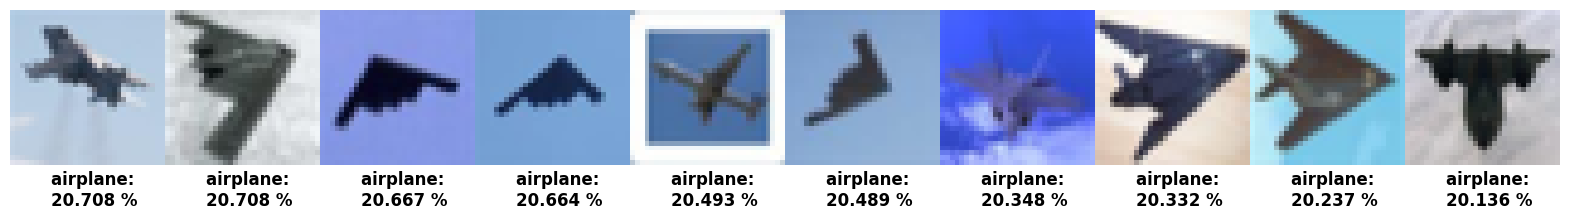

Accuracy of first test modele : 21.96%
313/313 [==============================] - 1s 2ms/step


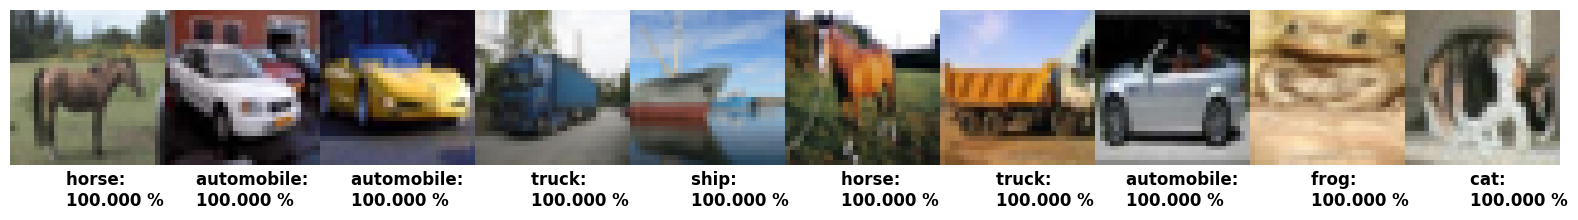

Accuracy of my optimized model : 48.76%


In [ ]:
# Final Tests :

# Test of the function with the same hyperparameters as before
accuracy = train_and_evaluate_model(num_neurons=128, num_hidden_layers=2, activation_function='sigmoid', learning_rate=0.001, optimizer_name='sgd', epochs=20, batch_size=128)
print(f"Accuracy of first test modele : {accuracy:.2f}%")

# Test with the new hyperparameters
accuracy = train_and_evaluate_model(num_neurons=128, num_hidden_layers=3, activation_function='relu', learning_rate=0.001, optimizer_name='adam', epochs=10, batch_size=128)
print(f"Accuracy of my optimized model : {accuracy:.2f}%")